## 1. 데이터 불러오기

In [147]:
import pandas as pd

data2=pd.read_excel('data/data2.xlsx', sheet_name='data2', header=0)

print(data2.columns[-29:])
data2 = data2.iloc[:, -29:]
# replace 0 to small value such as 1e-6
data2 = data2.replace(0, 1e-6)

print(data2)

Index(['H1_Read_Count', 'H2_Read_Count', 'H3_Read_Count', 'H4_Read_Count',
       'H5_Read_Count', 'H6_Read_Count', 'H7_Read_Count', 'H8_Read_Count',
       'H9_Read_Count', 'H10_Read_Count', 'M1_Read_Count', 'M2_Read_Count',
       'M3_Read_Count', 'M4_Read_Count', 'M5_Read_Count', 'M7_Read_Count',
       'M8_Read_Count', 'M9_Read_Count', 'M10_Read_Count', 'A1_Read_Count',
       'A2_Read_Count', 'A3_Read_Count', 'A4_Read_Count', 'A5_Read_Count',
       'A6_Read_Count', 'A7_Read_Count', 'A8_Read_Count', 'A9_Read_Count',
       'A10_Read_Count'],
      dtype='object')
     H1_Read_Count  H2_Read_Count  H3_Read_Count  H4_Read_Count  \
0            167.0           72.0           56.0           96.0   
1          18873.0        13820.0        10152.0        33595.0   
2            227.0          176.0          129.0          134.0   
3          43724.0        33721.0        19598.0        46927.0   
4            896.0          618.0          471.0          848.0   
..             ...     

## 2. 데이터 변환

두가지 방법 모두 해봣는데 , 큰차이는 없는듯 합니다.  
1. log-transform :probability 에 log를 취해서 범위를 (0, 무한대)사이로 
2. clr-log transform: 위와같이 probability형태는 더하면 1이라는 제약조건을 만족시켜야 하기 떄문에 aitchson geometry에서 사용한 clr-log transformation을 사용. 
(clr-log transformation은 https://hongl.tistory.com/173)참고

In [148]:
# for each person(which is column in data2), normalizationa need to be performed I would divide by total number for that person
data2_normalized = data2.div(data2.sum(axis=0), axis=1)
#print(data2_normalized)

# clr transformation
import numpy as np

def clr_transform(matrix):
    log_matrix = np.log(matrix)
    geometric_means = log_matrix.mean(axis=0)
    clr_matrix = log_matrix.subtract(geometric_means, axis=1)
    return clr_matrix

def simple_log_transform(matrix):
    return -np.log(matrix) #negative value for minus log transformation



log_df = simple_log_transform(data2_normalized) 
clr_df = clr_transform(data2_normalized)


print(log_df.iloc[0,:5])
print(clr_df.iloc[0,:5])


H1_Read_Count    7.162235
H2_Read_Count    7.655529
H3_Read_Count    7.522854
H4_Read_Count    7.776902
H5_Read_Count    9.628831
Name: 0, dtype: float64
H1_Read_Count    1.034383
H2_Read_Count    0.788553
H3_Read_Count    1.367239
H4_Read_Count    0.579957
H5_Read_Count    3.280683
Name: 0, dtype: float64


In [149]:
# now, i want to perform simple clustering on the clr transformed data
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

clr_data = clr_df
n_clusters = 5  # 원하는 클러스터 수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(clr_data)

# 결과 저장
clr_data['cluster'] = labels

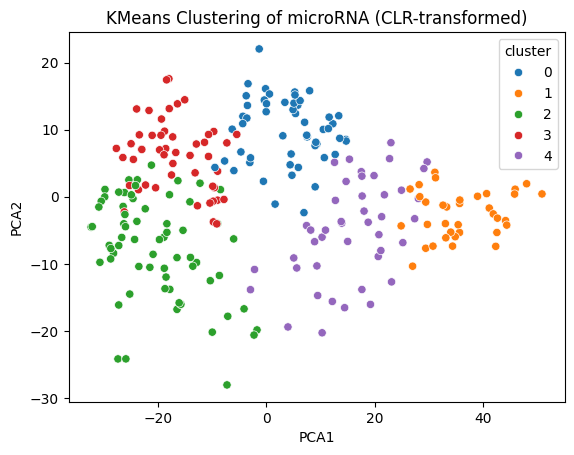

In [150]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(clr_data.drop('cluster', axis=1))
clr_data['PCA1'] = pca_result[:, 0]
clr_data['PCA2'] = pca_result[:, 1]

# Plot
sns.scatterplot(data=clr_data, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of microRNA (CLR-transformed)")
plt.show()

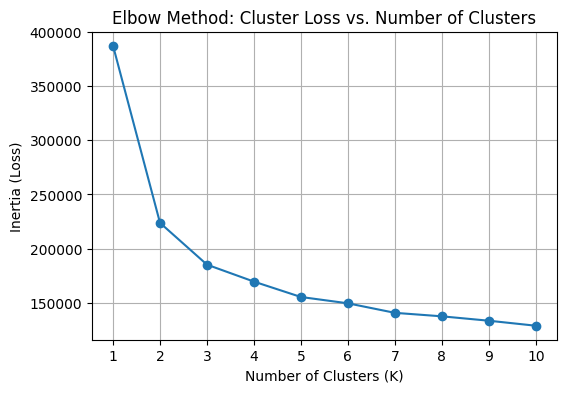

In [151]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 범위 설정 (예: 1~10 클러스터)
K_range = range(1, 11)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clr_data.drop(columns='cluster', errors='ignore'))  # sample x feature
    inertias.append(kmeans.inertia_)  # inertia = sum of squared distances to cluster centers
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method: Cluster Loss vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Loss)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

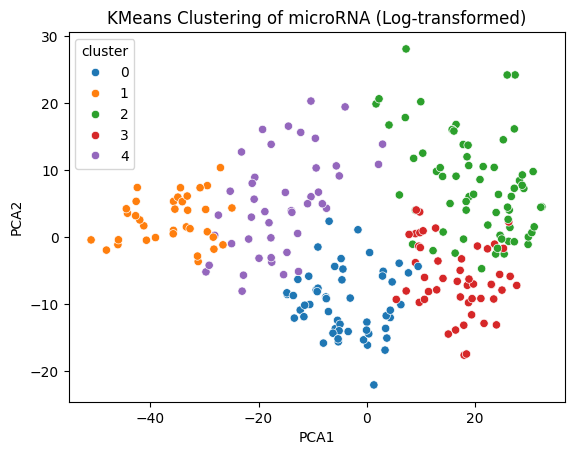

In [152]:
# do the same for log transformed data
log_data = log_df
n_clusters = 5  # 원하는 클러스터 수
kmeans_log = KMeans(n_clusters=n_clusters, random_state=42)
labels_log = kmeans_log.fit_predict(log_data)
# 결과 저장
log_data['cluster'] = labels_log
pca_log = PCA(n_components=2)
pca_result_log = pca_log.fit_transform(log_data.drop('cluster', axis=1))
log_data['PCA1'] = pca_result_log[:, 0]
log_data['PCA2'] = pca_result_log[:, 1]
# Plot
sns.scatterplot(data=log_data, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of microRNA (Log-transformed)")
plt.show()


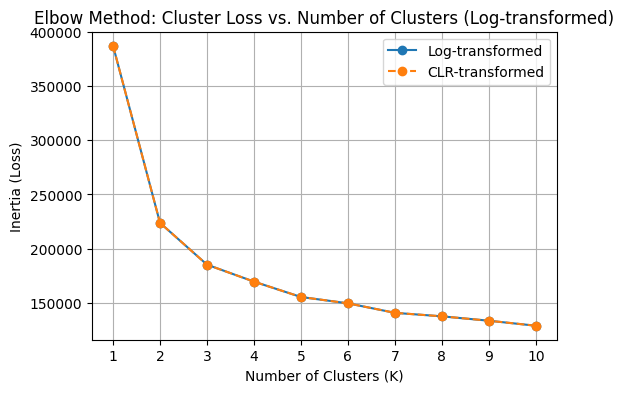

In [157]:

# Elbow method for log transformed data
inertias_log = []
for k in K_range:
    kmeans_log = KMeans(n_clusters=k, random_state=42)
    kmeans_log.fit(log_data.drop(columns='cluster', errors='ignore'))  # sample x feature
    inertias_log.append(kmeans_log.inertia_)  # inertia = sum of squared distances to cluster centers
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias_log, marker='o', label='Log-transformed')
# plot clr together with log transformed data
plt.plot(K_range, inertias, marker='o', label='CLR-transformed', linestyle='--')
plt.legend()
plt.title('Elbow Method: Cluster Loss vs. Number of Clusters (Log-transformed)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Loss)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [154]:
# setting cluster number as 5, I want to do the clustering for data_clr[:10] and data_clr[10:20], data_clr[20:30]

clr_data = log_df
n_clusters = 5  # 원하는 클러스터 수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(clr_data)

# 결과 저장

clr_data['cluster'] = labels




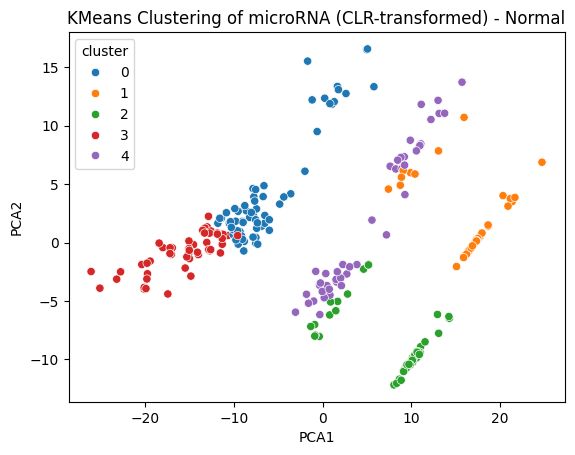

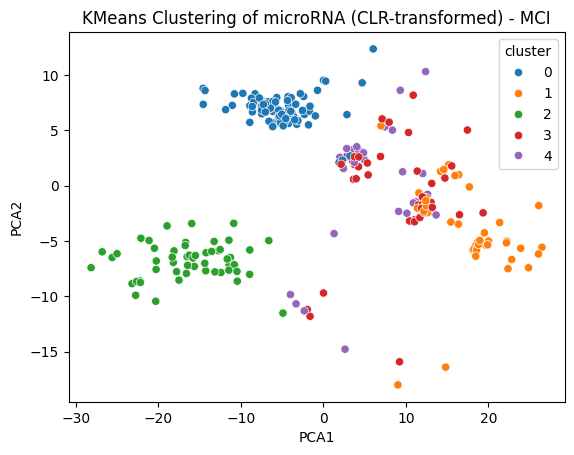

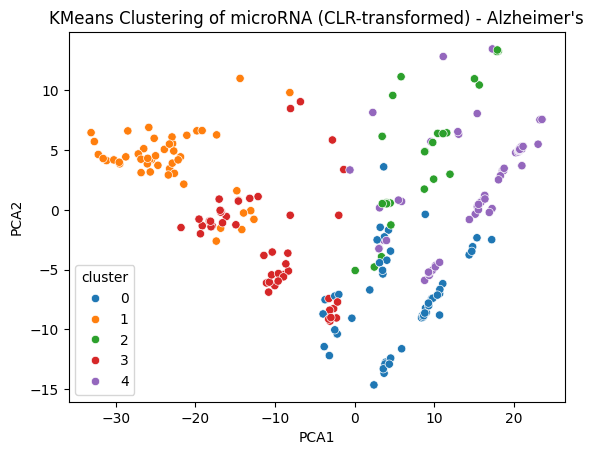

In [155]:
#I want to do the clustering for data_clr[:10] and data_clr[10:20], data_clr[20:30]

clr_data_1 = clr_data.iloc[:, :10]
clr_data_2 = clr_data.iloc[:, 10:20]
clr_data_3 = clr_data.iloc[:, 20:30]
#kmeans_1 = KMeans(n_clusters=n_clusters, random_state=42)
labels_1 = kmeans.fit_predict(clr_data_1)
#kmeans_2 = KMeans(n_clusters=n_clusters, random_state=42)
labels_2 = kmeans.fit_predict(clr_data_2)
#kmeans_3 = KMeans(n_clusters=n_clusters, random_state=42)
labels_3 = kmeans.fit_predict(clr_data_3)
# 결과 저장

clr_data_1['cluster'] = labels_1
clr_data_2['cluster'] = labels_2
clr_data_3['cluster'] = labels_3
# Plotting the clusters for each segment
# do the Pca
pca_1 = PCA(n_components=2)
pca_result_1 = pca.fit_transform(clr_data_1.drop('cluster', axis=1))
clr_data_1['PCA1'] = pca_result_1[:, 0]
clr_data_1['PCA2'] = pca_result_1[:, 1]
pca_2 = PCA(n_components=2)
pca_result_2 = pca.fit_transform(clr_data_2.drop('cluster', axis=1))
clr_data_2['PCA1'] = pca_result_2[:, 0]
clr_data_2['PCA2'] = pca_result_2[:, 1]
pca_3 = PCA(n_components=2)
pca_result_3 = pca.fit_transform(clr_data_3.drop('cluster', axis=1))
clr_data_3['PCA1'] = pca_result_3[:, 0]
clr_data_3['PCA2'] = pca_result_3[:, 1]
# Plotting the clusters for each segment
sns.scatterplot(data=clr_data_1, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of microRNA (CLR-transformed) - Normal")
plt.show()
sns.scatterplot(data=clr_data_2, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of microRNA (CLR-transformed) - MCI")
plt.show()
sns.scatterplot(data=clr_data_3, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of microRNA (CLR-transformed) - Alzheimer's")
plt.show()


In [ ]:


# now, i want to do the hypothesis testing for each cluster 
from scipy.stats import ttest_ind

# Assuming clr_data_1, clr_data_2, and clr_data_3 are the dataframes for each segment


# Perform t-tests for each cluster

cluster_0_data_1 = clr_data_1[clr_data_1['cluster'] == 0].values
cluster_0_data_2 = clr_data_2[clr_data_2['cluster'] == 0].values
cluster_0_data_3 = clr_data_3[clr_data_3['cluster'] == 0].values
cluster_0_data_1=cluster_0_data_1.reshape(cluster_0_data_1.shape[0]*cluster_0_data_1.shape[1],-1)
cluster_0_data_2=cluster_0_data_2.reshape(cluster_0_data_2.shape[0]*cluster_0_data_2.shape[1],-1)
cluster_0_data_3=cluster_0_data_3.reshape(cluster_0_data_3.shape[0]*cluster_0_data_3.shape[1],-1)
from scipy.stats import ttest_ind

t_stat_0, p_value_0 = ttest_ind(cluster_0_data_1, cluster_0_data_2, equal_var=False)
print(f"Cluster 0: t-statistic = {t_stat_0}, p-value = {p_value_0}")

t_stat_0_3, p_value_0_3 = ttest_ind(cluster_0_data_1, cluster_0_data_3, equal_var=False)
print(f"Cluster 0 (Normal vs Alzheimer's): t-statistic = {t_stat_0_3}, p-value = {p_value_0_3}")
t_stat_0_2, p_value_0_2 = ttest_ind(cluster_0_data_2, cluster_0_data_3, equal_var=False)
print(f"Cluster 0 (MCI vs Alzheimer's): t-statistic = {t_stat_0_2}, p-value = {p_value_0_2}")
# Repeat for other clusters
cluster_1_data_1 = clr_data_1[clr_data_1['cluster'] == 1].values
cluster_1_data_2 = clr_data_2[clr_data_2['cluster'] == 1].values
cluster_1_data_3 = clr_data_3[clr_data_3['cluster'] == 1].values
cluster_1_data_1=cluster_1_data_1.reshape(cluster_1_data_1.shape[0]*cluster_1_data_1.shape[1],-1)
cluster_1_data_2=cluster_1_data_2.reshape(cluster_1_data_2.shape[0]*cluster_1_data_2.shape[1],-1)
cluster_1_data_3=cluster_1_data_3.reshape(cluster_1_data_3.shape[0]*cluster_1_data_3.shape[1],-1)
t_stat_1, p_value_1 = ttest_ind(cluster_1_data_1, cluster_1_data_2, equal_var=False)
print(f"Cluster 1: (Normal vs MCI's) = {t_stat_1}, p-value = {p_value_1}")
t_stat_1_3, p_value_1_3 = ttest_ind(cluster_1_data_1, cluster_1_data_3, equal_var=False)
print(f"Cluster 1 (Normal vs Alzheimer's): t-statistic = {t_stat_1_3}, p-value = {p_value_1_3}")
t_stat_1_2, p_value_1_2 = ttest_ind(cluster_1_data_2, cluster_1_data_3, equal_var=False)
print(f"Cluster 1 (MCI vs Alzheimer's): t-statistic = {t_stat_1_2}, p-value = {p_value_1_2}")
# Repeat for other clusters
cluster_2_data_1 = clr_data_1[clr_data_1['cluster'] == 2].values
cluster_2_data_2 = clr_data_2[clr_data_2['cluster'] == 2].values
cluster_2_data_3 = clr_data_3[clr_data_3['cluster'] == 2].values
cluster_2_data_1=cluster_2_data_1.reshape(cluster_2_data_1.shape[0]*cluster_2_data_1.shape[1],-1)
cluster_2_data_2=cluster_2_data_2.reshape(cluster_2_data_2.shape[0]*cluster_2_data_2.shape[1],-1)
cluster_2_data_3=cluster_2_data_3.reshape(cluster_2_data_3.shape[0]*cluster_2_data_3.shape[1],-1)
t_stat_2, p_value_2 = ttest_ind(cluster_2_data_1, cluster_2_data_2, equal_var=False)
print(f"Cluster 2:(Normal vs mci's) = {t_stat_2}, p-value = {p_value_2}")
t_stat_2_3, p_value_2_3 = ttest_ind(cluster_2_data_1, cluster_2_data_3, equal_var=False)
print(f"Cluster 2 (Normal vs Alzheimer's): t-statistic = {t_stat_2_3}, p-value = {p_value_2_3}")
t_stat_2_2, p_value_2_2 = ttest_ind(cluster_2_data_2, cluster_2_data_3, equal_var=False)

print(f"Cluster 2 (MCI vs Alzheimer's): t-statistic = {t_stat_2_2}, p-value = {p_value_2_2}")
# Repeat for other clusters
cluster_3_data_1 = clr_data_1[clr_data_1['cluster'] == 3].values
cluster_3_data_2 = clr_data_2[clr_data_2['cluster'] == 3].values
cluster_3_data_3 = clr_data_3[clr_data_3['cluster'] == 3].values
cluster_3_data_1=cluster_3_data_1.reshape(cluster_3_data_1.shape[0]*cluster_3_data_1.shape[1],-1)
cluster_3_data_2=cluster_3_data_2.reshape(cluster_3_data_2.shape[0]*cluster_3_data_2.shape[1],-1)
cluster_3_data_3=cluster_3_data_3.reshape(cluster_3_data_3.shape[0]*cluster_3_data_3.shape[1],-1)
t_stat_3, p_value_3 = ttest_ind(cluster_3_data_1, cluster_3_data_2, equal_var=False)
print(f"Cluster 3: (Normal vs MCI's) = {t_stat_3}, p-value = {p_value_3}")
t_stat_3_3, p_value_3_3 = ttest_ind(cluster_3_data_1, cluster_3_data_3, equal_var=False)
print(f"Cluster 3 (Normal vs Alzheimer's): t-statistic = {t_stat_3_3}, p-value = {p_value_3_3}")
t_stat_3_2, p_value_3_2 = ttest_ind(cluster_3_data_2, cluster_3_data_3, equal_var=False)
print(f"Cluster 3 (MCI vs Alzheimer's): t-statistic = {t_stat_3_2}, p-value = {p_value_3_2}")
# Repeat for other clusters
cluster_4_data_1 = clr_data_1[clr_data_1['cluster'] == 4].values
cluster_4_data_2 = clr_data_2[clr_data_2['cluster'] == 4].values
cluster_4_data_3 = clr_data_3[clr_data_3['cluster'] == 4].values
cluster_4_data_1=cluster_4_data_1.reshape(cluster_4_data_1.shape[0]*cluster_4_data_1.shape[1],-1)
cluster_4_data_2=cluster_4_data_2.reshape(cluster_4_data_2.shape[0]*cluster_4_data_2.shape[1],-1)
cluster_4_data_3=cluster_4_data_3.reshape(cluster_4_data_3.shape[0]*cluster_4_data_3.shape[1],-1)
t_stat_4, p_value_4 = ttest_ind(cluster_4_data_1, cluster_4_data_2, equal_var=False)
print(f"Cluster 4: (Normal vs MCI's) = {t_stat_4}, p-value = {p_value_4}")
t_stat_4_3, p_value_4_3 = ttest_ind(cluster_4_data_1, cluster_4_data_3, equal_var=False)
print(f"Cluster 4 (Normal vs Alzheimer's): t-statistic = {t_stat_4_3}, p-value = {p_value_4_3}")
t_stat_4_2, p_value_4_2 = ttest_ind(cluster_4_data_2, cluster_4_data_3, equal_var=False)
print(f"Cluster 4 (MCI vs Alzheimer's): t-statistic = {t_stat_4_2}, p-value = {p_value_4_2}")



Cluster 0: t-statistic = [-2.98340386], p-value = [0.00288598]
Cluster 0 (Normal vs Alzheimer's): t-statistic = [-10.0453098], p-value = [1.33762098e-22]
Cluster 0 (MCI vs Alzheimer's): t-statistic = [-8.19223385], p-value = [8.46474507e-16]
Cluster 1: (Normal vs mci's) = [-1.63482493], p-value = [0.10238983]
Cluster 1 (Normal vs Alzheimer's): t-statistic = [19.02559347], p-value = [7.35814909e-70]
Cluster 1 (MCI vs Alzheimer's): t-statistic = [19.64773417], p-value = [4.31360248e-74]
Cluster 2:(Normal vs mci's) = [14.88515644], p-value = [3.52313258e-46]
Cluster 2 (Normal vs Alzheimer's): t-statistic = [-7.44071261], p-value = [3.21354687e-13]
Cluster 2 (MCI vs Alzheimer's): t-statistic = [-19.70504297], p-value = [9.21523732e-66]
Cluster 3: (Normal vs mci's) = [-19.5332341], p-value = [8.73328858e-73]
Cluster 3 (Normal vs Alzheimer's): t-statistic = [-8.1982382], p-value = [7.58365159e-16]
Cluster 3 (MCI vs Alzheimer's): t-statistic = [8.6663982], p-value = [1.56330834e-17]
Cluster 4